In [1]:
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
alt.data_transformers.enable("data_server")

DataTransformerRegistry.enable('data_server')

In [3]:
df = pd.read_csv("who_life_tables.csv")
df

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
0,LIFE_0000000029,nMx - age-specific death rate between ages x a...,numeric,EUR,Europe,Country,DNK,Denmark,Year,2019,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,EN,2020-12-05T23:00:00.000Z
1,LIFE_0000000029,nMx - age-specific death rate between ages x a...,numeric,EUR,Europe,Country,ISL,Iceland,Year,2019,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,EN,2020-12-05T23:00:00.000Z
2,LIFE_0000000029,nMx - age-specific death rate between ages x a...,numeric,EUR,Europe,Country,ISL,Iceland,Year,2019,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,EN,2020-12-05T23:00:00.000Z
3,LIFE_0000000029,nMx - age-specific death rate between ages x a...,numeric,EUR,Europe,Country,ISR,Israel,Year,2019,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,EN,2020-12-05T23:00:00.000Z
4,LIFE_0000000029,nMx - age-specific death rate between ages x a...,numeric,EUR,Europe,Country,LUX,Luxembourg,Year,2019,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,EN,2020-12-05T23:00:00.000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243385,LIFE_0000000035,ex - expectation of life at age x,numeric,AFR,Africa,Country,COM,Comoros,Year,2000,...,NaN,NaN,NaN,NaN,NaN,9.96,NaN,NaN,EN,2020-12-05T23:00:00.000Z
243386,LIFE_0000000035,ex - expectation of life at age x,numeric,EUR,Europe,Country,KGZ,Kyrgyzstan,Year,2000,...,NaN,NaN,NaN,NaN,NaN,9.96,NaN,NaN,EN,2020-12-05T23:00:00.000Z
243387,LIFE_0000000035,ex - expectation of life at age x,numeric,AMR,Americas,Country,VEN,Venezuela (Bolivarian Republic of),Year,2000,...,NaN,NaN,NaN,NaN,NaN,9.97,NaN,NaN,EN,2020-12-05T23:00:00.000Z
243388,LIFE_0000000035,ex - expectation of life at age x,numeric,AFR,Africa,Country,MUS,Mauritius,Year,2000,...,NaN,NaN,NaN,NaN,NaN,9.98,NaN,NaN,EN,2020-12-05T23:00:00.000Z


In [4]:
df.Indicator.value_counts()

nMx - age-specific death rate between ages x and x+n    34770
nqx - probability of dying between ages x and x+n       34770
lx - number of people left alive at age x               34770
ndx - number of people dying between ages x and x+n     34770
nLx - person-years lived between ages x and x+n         34770
Tx - person-years lived above age x                     34770
ex - expectation of life at age x                       34770
Name: Indicator, dtype: int64

In [5]:
ex = df.loc[lambda f: f["Indicator"].str.startswith("ex")]
ex.columns = ex.columns.str.lower()

In [6]:
ex.iloc[0]

indicatorcode                                   LIFE_0000000035
indicator                     ex - expectation of life at age x
valuetype                                               numeric
parentlocationcode                                          WPR
parentlocation                                  Western Pacific
location type                                           Country
spatialdimvaluecode                                         PHL
location                                            Philippines
period type                                                Year
period                                                     2019
islatestyear                                               True
dim1 type                                                   Sex
dim1                                                       Male
dim1valuecode                                               MLE
dim2 type                                             Age Group
dim2                                    

In [7]:
ex2 = (
    ex.join(
        ex["dim2"]
        .str.replace(r"<", r"0-")
        .str.extract(r"(?P<lower>\d+)-?\s*(?P<upper>\d+|\+)", expand=True)
        .replace("+", np.inf)
        .astype(float)
    )
    .dropna(how="all", axis=1)
    .assign(remaining=lambda f: f["value"].astype(float))
    .rename({"dim1": "sex", "spatialdimvaluecode": "country_code"}, axis=1)
    .assign(
        mid=lambda f: f["lower"].add(f["upper"].replace(np.inf, 90)).div(2),
        total=lambda f: f["mid"].add(f["remaining"]),
    )
    .set_index(["location", "period", "sex", "lower", "upper"])
    .sort_index()[["country_code", "parentlocation", "mid", "total", "remaining"]]
)

In [8]:
ex2

country_code         parentlocation  \
location    period sex    lower upper                                       
Afghanistan 2000   Female 0.0   1.0            AFG  Eastern Mediterranean   
                          1.0   4.0            AFG  Eastern Mediterranean   
                          5.0   9.0            AFG  Eastern Mediterranean   
                          10.0  14.0           AFG  Eastern Mediterranean   
                          15.0  19.0           AFG  Eastern Mediterranean   
...                                            ...                    ...   
Zimbabwe    2019   Male   65.0  69.0           ZWE                 Africa   
                          70.0  74.0           ZWE                 Africa   
                          75.0  79.0           ZWE                 Africa   
                          80.0  84.0           ZWE                 Africa   
                          85.0  inf            ZWE                 Africa   

                                        mid  total  remaining  
location    period sex    lower upper                          
Afghanistan 2000   Female 0.0   1.0     0.5  55.92      55.42  
                          1.0   4.0     2.5  62.05      59.55  
                          5.0   9.0     7.0  65.16      58.16  
                          10.0  14.0   12.0  65.52      53.52  
                          15.0  19.0   17.0  65.70      48.70  
...                                     ...    ...        ...  
Zimbabwe    2019   Male   65.0  69.0   67.0  78.20      11.20  
                          70.0  74.0   72.0  81.03       9.03  
                          75.0  79.0   77.0  84.12       7.12  
                          80.0  84.0   82.0  87.45       5.45  
                          85.0  inf    87.5  91.55       4.05  

[34770 rows x 5 columns]

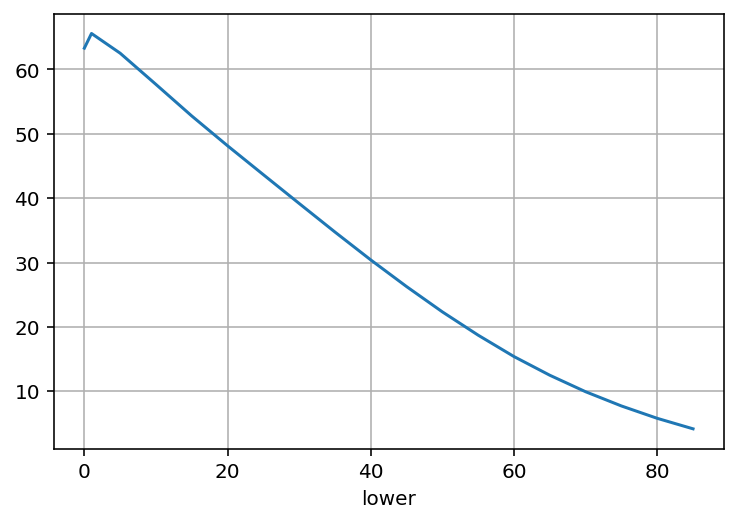

In [9]:
ex2.loc[("Afghanistan", 2019, "Male"), "remaining"].reset_index().set_index("lower")[
    "remaining"
].plot()
plt.grid()

<AxesSubplot:xlabel='mid'>

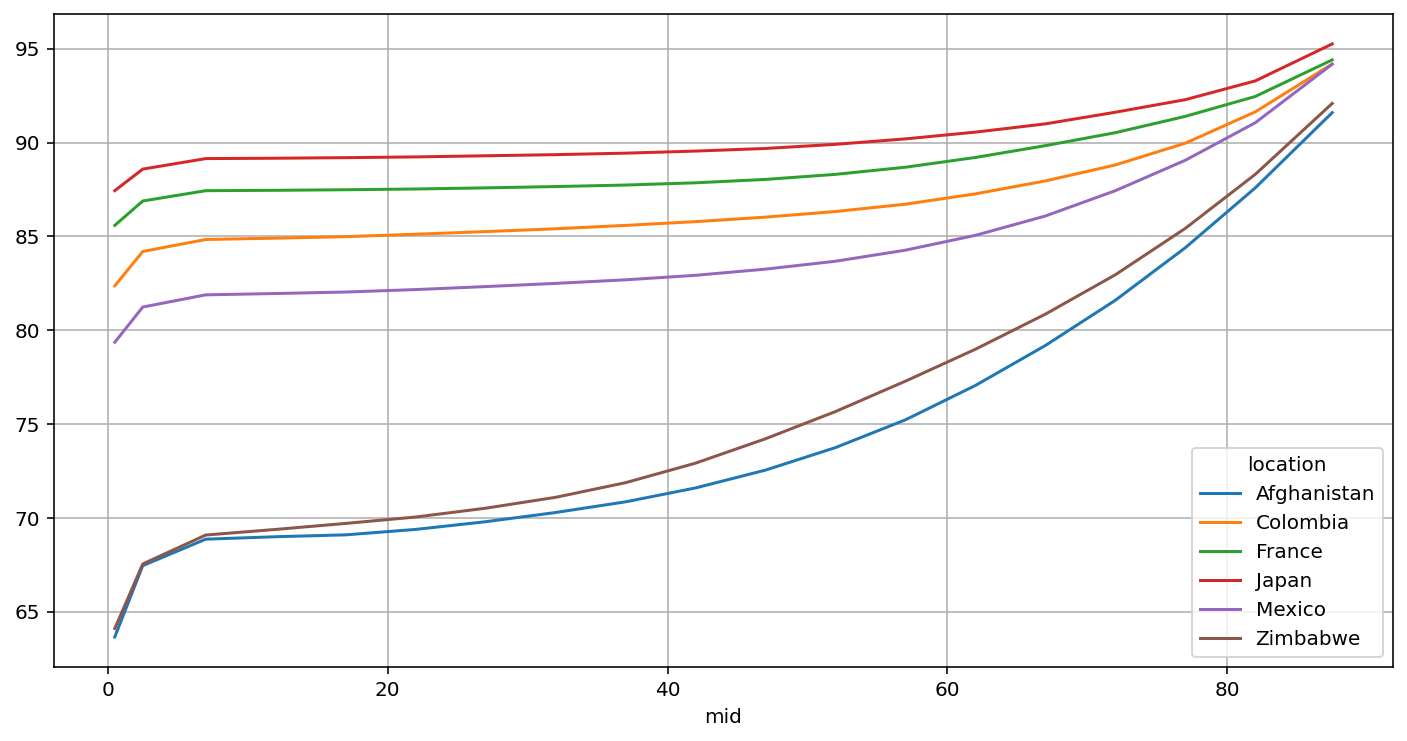

In [10]:
(
    ex2.query(
        "location in ('France', 'Afghanistan', 'Zimbabwe', 'Japan', 'Mexico', 'Colombia') and period == 2019 and sex == 'Female'"
    )
    .reset_index()
    .set_index(["location", "mid"])["total"]
    .unstack("location")
    .plot(grid=True, figsize=(12, 6))
)

In [11]:
# (
#     ex2.groupby(["parentlocation", "mid"])["total"]
#     .agg(["min", "max", "median", "mean"])
#     .rename_axis("kpi", axis=1)
#     .stack()
#     .unstack("parentlocation")
#     .groupby("kpi")
#     .apply(lambda g: (g.reset_index("kpi", drop=True).plot(title=g.name, figsize=(20, 10), grid=True, ylim=0)))
# )

In [12]:
one = ex2.loc[("Afghanistan", 2019, "Male"), :]
two = ex2.loc[("France", 2019, "Male"), :]


# def fun(x, a):
#     return x + a * np.exp(-(x + 10) / 50)


# paramsA, _ = curve_fit(fun, one["mid"].values, one["total"].values)
# paramsB, _ = curve_fit(fun, two["mid"].values, two["total"].values)
# print(paramsA, paramsB, sep="\n")

# plt.subplots(figsize=(12, 6))

# plt.plot(one["mid"].values, fun(one["mid"], *paramsA).values)
# one.set_index("mid")["total"].plot()

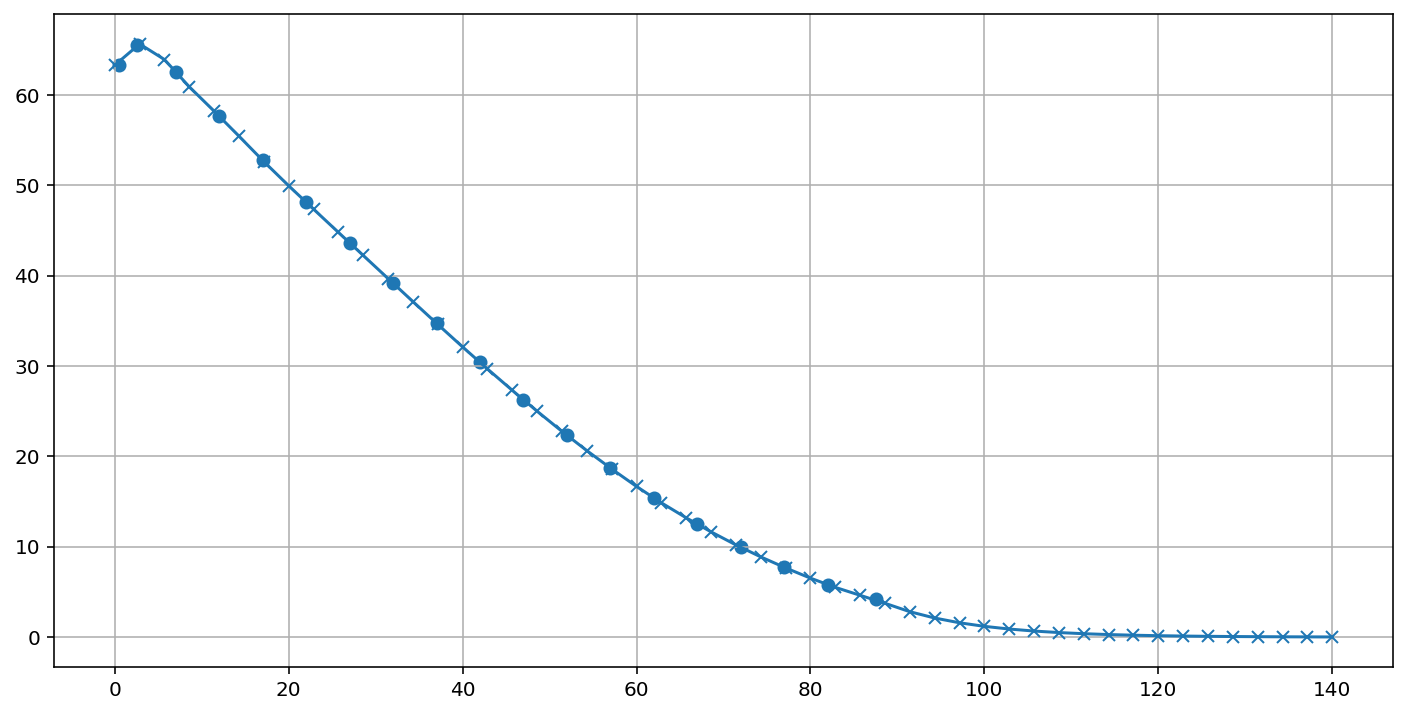

In [14]:
plt.subplots(figsize=(12, 6))

interpolated = interp1d(
    one["mid"].values,
    one["remaining"].values,
    kind="cubic",
    bounds_error=False,
    fill_value=np.nan
)
def f(x):
    xmax = interpolated.x.max()
    value = interpolated(x).squeeze()
    if value == value:
        return value
    if x < interpolated.x.min():
        return interpolated.y[0]
    elif x > xmax:
        pt = interpolated.y[-1]
        return pt * np.exp(- (x - xmax) / 10)
    
fv = np.vectorize(f)

x = np.linspace(0, 140, 50)
plt.plot(x, fv(x), marker="x")
plt.scatter(one["mid"].values, one["remaining"].values)
plt.grid()
# plt.ylim(0)